In [224]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter


In [225]:
## Кузминик, тест 2, до 8 GPS
START_ID, FFK_criterion = 46388, 'GDOP'
LLA = [55.692656, 37.771607, 130]
###############################################
## Кузьминики с ГЛОНАСС
START_ID, FFK_criterion = 49762, 'GDOP'
#
START_ID, FFK_criterion = 69316, 'norm P'
# ALL
START_ID, FFK_criterion = 70293, 'norm P'
# ALL
START_ID, FFK_criterion = 90834, 'GDOP'





In [226]:
folder = 'serialized_data\\'
normP_deadline = 0.0010704662693191
GDOP_deadline = 101
MS = 10

In [227]:
LLA = [55.692656, 37.771607, 130]
from Transformations import *
XYZ = list(lla2ecef(*LLA))
print(LLA)
print(XYZ)
receiver_error = 500
ERROR = 5000
# ERROR = 100
MAX_ERROR_xyz = [ERROR] * 3
MAX_ERROR_lla = [ERROR / 100000, ERROR / 100000, ERROR]

[55.692656, 37.771607, 130]
[np.float64(2848207.018610182), np.float64(2207036.0341782332), np.float64(5245338.3874627035)]


In [228]:
def filter1(fk: pd.DataFrame, format, is_receiver=False):
    fk = fk[fk.GDOP < GDOP_deadline]
    fk = fk[fk.normP > normP_deadline]
    coords = XYZ if format == 'xyz' else LLA
    MAX_ERROR = MAX_ERROR_xyz if format == 'xyz' else MAX_ERROR_lla
    k = receiver_error / ERROR if is_receiver else 1
    if k > 1:
        k = 1
    coords = list(coords)
    # print(fk.columns)
    for i in range(3):
        fk = fk[abs(fk[f'state_{i}'] - coords[i]) < MAX_ERROR[i] * k]
    #     print(coords[i])
    #     fk = fk[fk['state'].apply(lambda state: abs(np.fromstring(state.replace('[', '').replace(']', ''), sep=' ')[i] - coords[i]) < MAX_ERROR) ]
    # try:
    #     fk = fk[np.linalg.norm(np.array(fk.state) - np.array(coords)) < MAX_ERROR]
    # except:
    #     print(fk.state)
    #     print(type(fk.state))
    return fk
    

In [229]:
def lkf_drawer(lkf_list: dict[(str, str), pd.DataFrame], format):
    fig, axs = plt.subplots(4, figsize=(14, 10))
    plt.suptitle(f'Coordinates and quality of receiver position \nfor many sources in {format} format')
    for (gnss, dataType), lkf in lkf_list.items():
        lkf = filter1(lkf, format, is_receiver=(gnss in ['default', 'receiver'] ))
        label = f'{gnss}-{dataType}' if gnss != 'default' else 'receiver'
        if dataType == 'ALM':
            marker = '.'
        elif dataType == 'EPH':
            marker = '*'
        else:
            marker = '^'
        for i in range(3):    
            axs[i].scatter(lkf.TOW, lkf.state.apply(lambda state: np.fromstring(state.replace('[', '').replace(']', ''), sep=' ')[i]), label=label, s=MS * (0.7 if dataType == 'ALM' else 1 ), marker=marker)
            # coords = XYZ if format == 'xyz' else LLA
            # axs[i].set_ylim([coords[i] - MAX_ERROR, coords[i] + MAX_ERROR])
            # axs[i].axhline(y=coords[i], linestyle='--', label='real')
            
        if FFK_criterion == 'GDOP':
            axs[3].scatter(lkf.TOW, lkf.GDOP, label=label, s=MS, marker=marker)
        elif FFK_criterion == '||P||' or FFK_criterion == 'norm P':
            axs[3].scatter(lkf.TOW, lkf.normP, label=label, s=MS, marker=marker)
        else:
            pass
        
        # axs[4].scatter(lkf.TOW, lkf.normP, label=f'{gnss}-{dataType}', s=MS)
        # axs[4].scatter(lkf.TOW, lkf.norm_derivative, label=label, s=MS)
    axs[3].set_ylabel(FFK_criterion)
    # axs[4].set_ylabel('normP')
    # axs[4].set_ylabel('||derivative||')
    
    if format == 'xyz':
        for i in range(3):
            # axs[i].plot([min(lkf.TOW), max(lkf.TOW)], [XYZ[i], XYZ[i]], 'red', '--')
            axs[i].set_ylabel(f'{'XYZ'[i]}, m')
            axs[i].axhline(y=XYZ[i], linestyle='--', label='real', color='red')
    if format == 'lla':
        labels = ['lat', 'lon', 'alt']
        for i in range(3):
            # axs[i].plot([min(lkf.TOW), max(lkf.TOW)], [LLA[i], LLA[i]], 'red', '--')
            axs[i].set_ylabel(f'{labels[i]}, deg')
            axs[i].axhline(y=LLA[i], linestyle='--', label='real', color='red')
        axs[2].set_ylabel(f'{labels[2]}, m')
        # axs[2].set_ylim((-1000, 1000))
    for i in range(4):
        axs[i].grid()
        axs[i].legend(loc='upper right')
        axs[i].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Отключаем смещение и экспоненциальный формат
        axs[i].ticklabel_format(style='plain')  # Устанавливаем обычное форматирование чисел
    axs[-1].set_xlabel('time, sec')
    plt.savefig(f'{folder}lkf_{format}_{START_ID}_{ERROR}.png', dpi=600)

In [230]:
def fkf_drawer(fkf: pd.DataFrame, format, used_sources: list[(str, str)]):
    fig, axs = plt.subplots(4, figsize=(14, 10))
    plt.suptitle(f'Coordinates and quality of receiver position \nfor many sources in {format} format with {FFK_criterion} criterion')
    for (gnss, dataType) in used_sources:
        data = fkf[(fkf.source_gnss == gnss) & (fkf.source_dataType == dataType)]
        data = filter1(data, format, is_receiver=(gnss in ['default', 'receiver'] ))
        label = f'{gnss}-{dataType}' if gnss != 'default' else 'receiver'
        if dataType == 'ALM':
            marker = 'o'
        elif dataType == 'EPH':
            marker = '*'
        else:
            marker = '^'
        for i in range(3):
            axs[i].scatter(data.TOW, data.state.apply(lambda state: np.fromstring(state.replace('[', '').replace(']', ''), sep=' ')[i]), label=label, s=MS * (0.7 if dataType == 'ALM' else 1 ), marker=marker)
            # axs[i].scatter(data.TOW, data.state.apply(lambda state: np.fromstring(state.replace('[', '').replace(']', ''), sep=' ')[i]), label=label, s=MS)
            # coords = XYZ if format == 'xyz' else LLA
            # axs[i].set_ylim([coords[i] - MAX_ERROR, coords[i] + MAX_ERROR])
            
        if FFK_criterion == 'GDOP':
            axs[3].scatter(data.TOW, data.GDOP, label=label, s=MS, marker=marker)
        elif FFK_criterion == '||P||' or FFK_criterion == 'norm P':
            axs[3].scatter(data.TOW, data.normP, label=label, s=MS, marker=marker)
        else:
            pass
        
        # axs[4].scatter(data.TOW, data.normP, label=f'{gnss}-{dataType}', s=MS)
        # axs[4].scatter(data.TOW, data.norm_derivative, label=label, s=MS)
    axs[3].set_ylabel(FFK_criterion)
    # axs[4].set_ylabel('normP')
    # axs[4].set_ylabel('||derivative||')
    if format == 'xyz':
        for i in range(3):
            # axs[i].plot([min(fkf.TOW), max(fkf.TOW)], [XYZ[i], XYZ[i]], 'red', '--')
            axs[i].axhline(y=XYZ[i], linestyle='--', label='real', color='red')
            axs[i].set_ylabel(f'{'XYZ'[i]}, m')
    if format == 'lla':
        labels = ['lat', 'lon', 'alt']
        for i in range(3):
            # axs[i].plot([min(fkf.TOW), max(fkf.TOW)], [LLA[i], LLA[i]], 'red', '--')
            axs[i].axhline(y=LLA[i], linestyle='--', label='real', color='red')
            axs[i].set_ylabel(f'{labels[i]}, deg')
        axs[2].set_ylabel(f'{labels[2]}, m')
        # axs[2].set_ylim((-1000, 1000))
    for i in range(4):
        axs[i].grid()
        axs[i].legend(loc='upper right')
        axs[i].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))  # Отключаем смещение и экспоненциальный формат
        axs[i].ticklabel_format(style='plain')  # Устанавливаем обычное форматирование чисел
    axs[-1].set_xlabel('time, sec')
    plt.savefig(f'{folder}fkf_{format}_{START_ID}_{FFK_criterion}_{ERROR}.png', dpi=600)

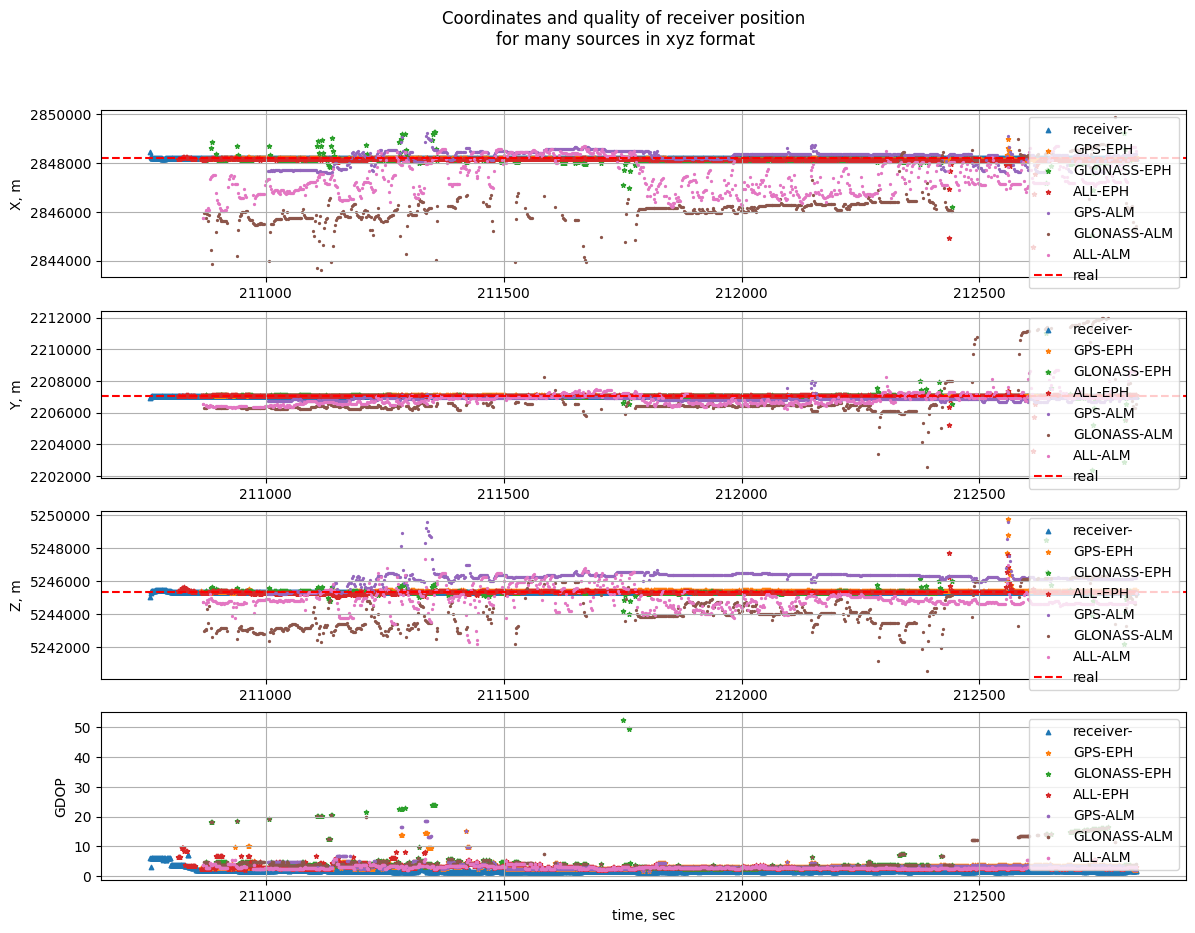

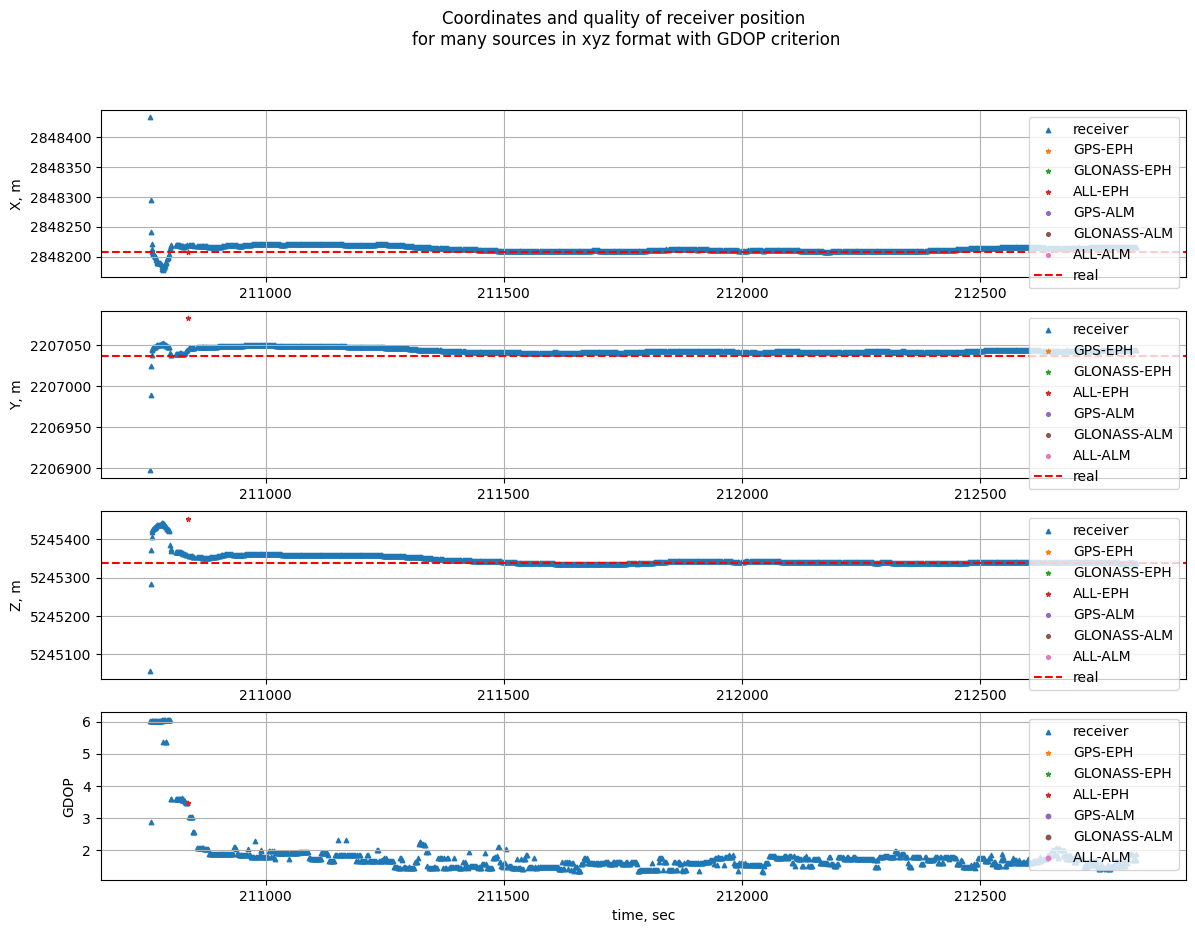

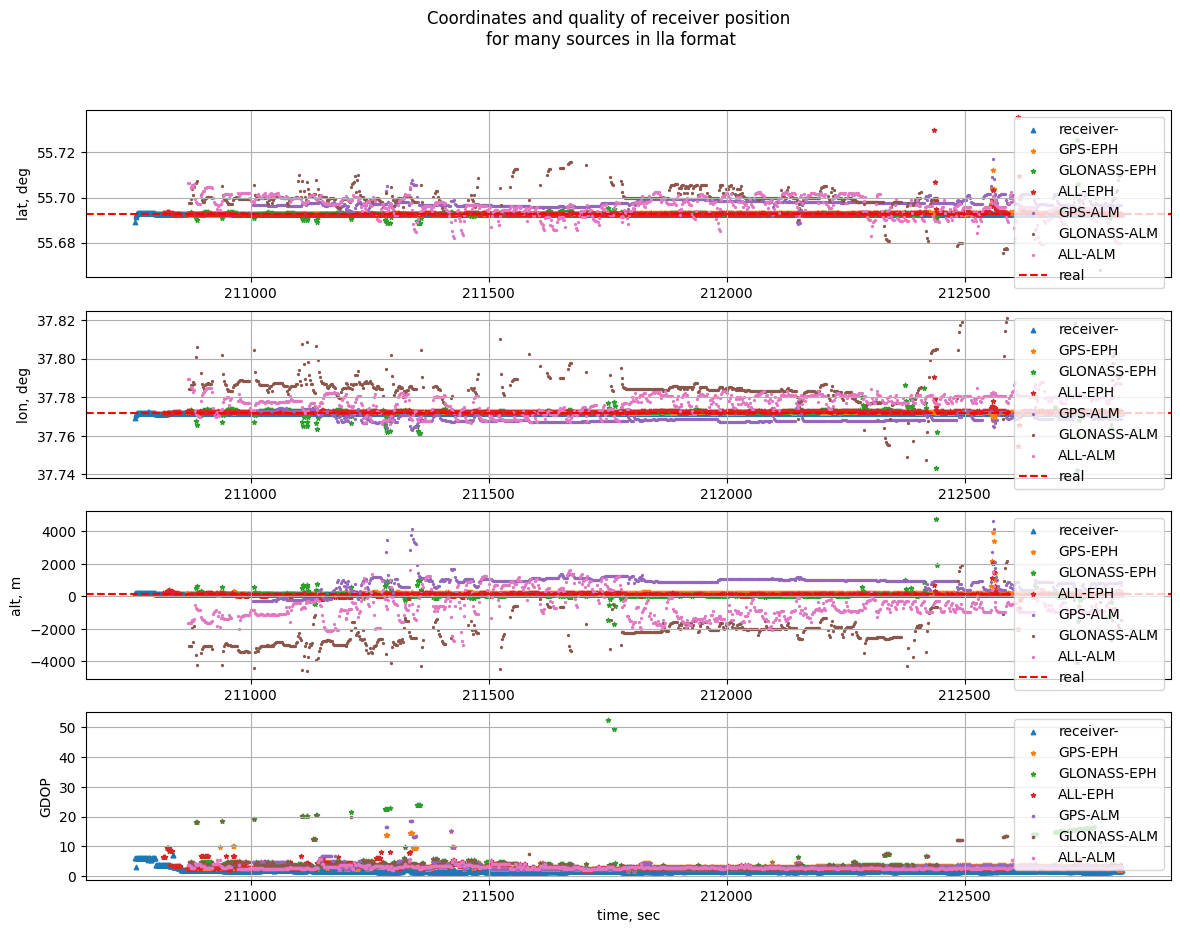

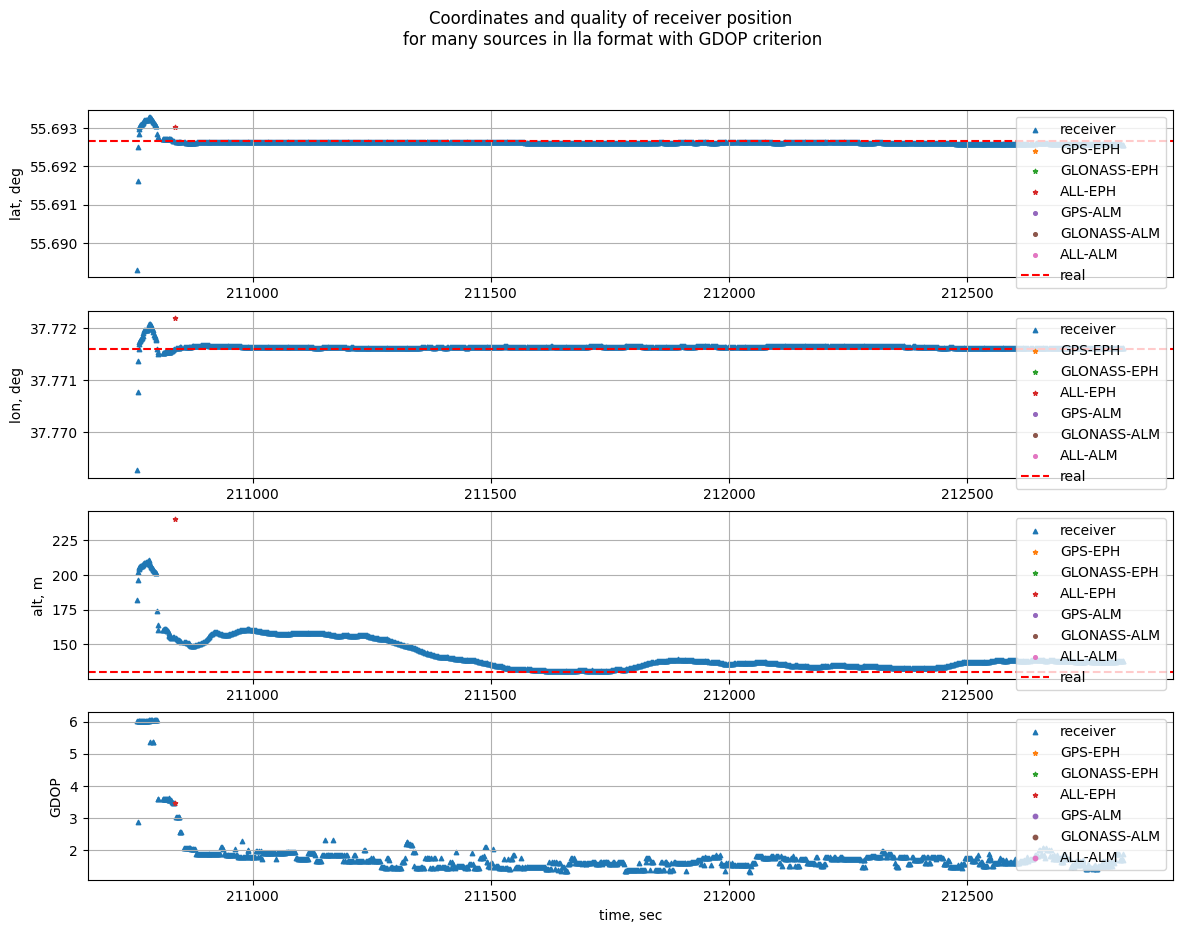

In [231]:
global X, Y
for format in ['xyz', 'lla']:
    fkf = pd.read_csv(f'{folder}fkf_{format}_{START_ID}.csv')
    # fkf.state = fkf.state.apply(lambda state: np.fromstring(state.replace('[', '').replace(']', ''), sep=' '))\
    for i in range(3):
        fkf[f'state_{i}'] = fkf.state.apply(lambda state: np.fromstring(state.replace('[', '').replace(']', ''), sep=' ')[i])
    lkf_filters = {}
    used_sources = [('default', 'default')]
    lfk = pd.read_csv(f'{folder}lkf_{format}_default_default_{START_ID}.csv')
    for i in range(3):
        lfk[f'state_{i}'] = lfk.state.apply(lambda state: np.fromstring(state.replace('[', '').replace(']', ''), sep=' ')[i])
    lkf_filters[('receiver', '')] = lfk
    for dataType in ['EPH', 'ALM']:
        for gnss in ['GPS', 'GLONASS', 'ALL']:
            try:
                lfk = pd.read_csv(f'{folder}lkf_{format}_{gnss}_{dataType}_{START_ID}.csv')
                # lfk.state = lfk.state.apply(lambda state: np.fromstring(state.replace('[', '').replace(']', ''), sep=' '))
                for i in range(3):
                    lfk[f'state_{i}'] = lfk.state.apply(lambda state: np.fromstring(state.replace('[', '').replace(']', ''), sep=' ')[i])
                lkf_filters[(gnss, dataType)] = lfk
                used_sources.append((gnss, dataType))
            except FileNotFoundError:
                pass
    
    
    
    a=0
    lkf_drawer(lkf_filters, format)
    fkf_drawer(fkf, format, used_sources)
    

In [232]:
# plt.scatter(lfk.TOW, lfk.normP, label='', s=MS)

In [233]:
LINES = []
for key, value in lkf_filters.items():
    lines = value[abs(value.TOW - 211800) < 0.4]
    LINES.append(lines)
    # print(lines.TOW)
    # print(lines.GDOP)#, lines.state)
    # print(value.GDOP.iloc[1000])
    # print(value.TOW.iloc[1000])
lines = fkf[abs(fkf.TOW - 211800) < 0.4]
print(lines)
# print(lines.TOW)
# print(lines.GDOP)

Empty DataFrame
Columns: [Unnamed: 0, TOW, week, state, P, normP, GDOP, fval, scores, derivative, norm_derivative, sat_count, source_gnss, source_dataType, state_0, state_1, state_2]
Index: []
